# テキストデータの処理

データの性質を示す特徴量

- 量を表現する連続値特徴量

- 決めたれたリストの中のアイテムを示すカテゴリ特徴量

- テキスト 🆕

# 文字列として表現されているデータのタイプ

文字列データの種類

- カテゴリデータ

- 意味的にはカテゴリに分類できる自由に書かれた文字列

- 構造化された文字列

- テキストデータ

## テキスト解析の用語

- データセット...

    コーパス(corpus)

- 一つのテキストとして表現される個々のデータポイント...

    文書(document)

In [1]:
# 映画レビューのセンチメント分析をする
# データのダウンロードはREADMEより
!tree -dL 2 data/aclImdb
# IPythonでは!lsのように先頭に!をつけることでシステムコマンド（OSコマンド / シェルコマンド）を実行できる。
# https://note.nkmk.me/jupyter-notebook-system-command/

data/aclImdb
├── test
│   ├── neg
│   └── pos
└── train
    ├── neg
    ├── pos
    └── unsup

7 directories


In [2]:
# unsupはいらないから消しておく
!rm -r data/aclImdb/train/unsup

In [5]:
# ラベルがサブフォルダに対応するフォルダ構造からデータを読み込むための関数がある
from sklearn.datasets import load_files

reviews_train = load_files("data/aclImdb/train/")
# load_filesは一連の訓練テキストと訓練ラベルを返す
text_train, y_train = reviews_train.data, reviews_train.target
print(f"Type of txst_train: {type(text_train)}")
print(f"length of text_train: {len(text_train)}")
print(f"text_train[1]:\n{text_train[1]}")

Type of txst_train: <class 'list'>
length of text_train: 25000
text_train[1]:
b'Words can\'t describe how bad this movie is. I can\'t explain it by writing only. You have too see it for yourself to get at grip of how horrible a movie really can be. Not that I recommend you to do that. There are so many clich\xc3\xa9s, mistakes (and all other negative things you can imagine) here that will just make you cry. To start with the technical first, there are a LOT of mistakes regarding the airplane. I won\'t list them here, but just mention the coloring of the plane. They didn\'t even manage to show an airliner in the colors of a fictional airline, but instead used a 747 painted in the original Boeing livery. Very bad. The plot is stupid and has been done many times before, only much, much better. There are so many ridiculous moments here that i lost count of it really early. Also, I was on the bad guys\' side all the time in the movie, because the good guys were so stupid. "Executive Decisio

In [6]:
# レビューにHTMLの改行シーケンスがあることがあるから、取り除いておく
text_train = [doc.replace(b"<br />", b" ") for doc in text_train]
# テキストはbyte型になっている→b""となっている
# https://www.kannon.link/fuku/index.php/2017/02/22/01-34/
# https://techacademy.jp/magazine/18885

In [8]:
# 肯定的なクラスと否定的なクラスがバランスするように集められている

import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import pandas as pd
import mglearn

print(f"Sample per class (training): {np.bincount(y_train)}")

Sample per class (training): [12500 12500]


In [9]:
# テストセットもロード
reviews_test = load_files("data/aclImdb/test/")
text_test, y_test = reviews_test.data, reviews_test.target
print(f"Number of documents in test data: {len(text_test)}")
print(f"Samples per class (test): {np.bincount(y_test)}")
text_test = [doc.replace(b"<br />", b" ") for doc in text_test]

Number of documents in test data: 25000
Samples per class (test): [12500 12500]


#  Bag of Wordsによるテキスト表現

章立て、パラグラフ、文章、フォーマットなどの文章の持つ構造を捨てて、コーパスに現れた単語がテキストに現れる回数だけが数えられる。
単語の現れる回数だけを数えるから、テキストを単語を入れる袋(bag)として考えている。

文章の表現であるコーパスに対してBoW表現を計算するステップ

1. トークン分割(tokenization)

    個々の文章を単語(トークン)に分割

1. ボキャブラリ構築(vocabulary building)

    全ての文書に現れる全ての単語をボキャブラリとして集め、番号をつける(例えばアルファベット順で)

1. エンコード

    個々の文書に対してボキャブラリの現れる回数を数える

詳しくはP.322

In [10]:
#  トイデータでBoWを試してみる。変換器としてCountVectorizerに実装されている
bards_words = ["The fool doth think he is wise,", "but the wise man knows himself to be a fool"]

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
vect.fit(bards_words)

CountVectorizer()

In [13]:
# CountVectorizerのfitでは、訓練データのトークン分割とボキャブラリ構築が行われる。
# ボキャブラリはvocabulary_属性で確認できる
print(f"Vocabulary size: {len(vect.vocabulary_)}")
print(f"Vocabulary content:\n{vect.vocabulary_}")

Vocabulary size: 13
Vocabulary content:
{'the': 9, 'fool': 3, 'doth': 2, 'think': 10, 'he': 4, 'is': 6, 'wise': 12, 'but': 1, 'man': 8, 'knows': 7, 'himself': 5, 'to': 11, 'be': 0}


In [14]:
# BoW表現を作るには、transformメソッドを呼び出す
bag_of_words = vect.transform(bards_words)
print(f"bag_of_words: {repr(bag_of_words)}")
# repr: objectをeval()で再び元のオブジェクトに戻せる文字列に変換して返す。representationの略。
# https://gammasoft.jp/blog/use-diffence-str-and-repr-python/

bag_of_words: <2x13 sparse matrix of type '<class 'numpy.int64'>'
	with 16 stored elements in Compressed Sparse Row format>


結果の詳しい説明はP.324へ

2行13列の行列で、2つのデータポイントに対して行が割り当てられる。

BoW表現は、SciPyの疎行列として格納されている。ほとんどの文書にはボキャブラリ中の単語のごく一部しか現れず、特徴量に対する要素のほとんどが0になるため。(メモリを節約できる)

疎行列の内容をみるには、toarrayメソッドを用いて「密な」NumPy行列に変換すればいい。

In [15]:
print(f"Dense representation of bag_of_words:\n{bag_of_words.toarray()}")
# 4番目のfool、10番目のthe、13番目のwiseが両方の文字列に出現している

Dense representation of bag_of_words:
[[0 0 1 1 1 0 1 0 0 1 1 0 1]
 [1 1 0 1 0 1 0 1 1 1 0 1 1]]


In [16]:
# 映画レビューのタスクにBoWを適用してみる
vect = CountVectorizer().fit(text_train)
X_train = vect.transform(text_train)
print(f"X_train:\n{repr(X_train)}")
# ボキャブラリは74849単語で構成されている

X_train:
<25000x74849 sparse matrix of type '<class 'numpy.int64'>'
	with 3431196 stored elements in Compressed Sparse Row format>


In [17]:
# ボキャブラリにアクセスする方法として、CountVectorizerのget_feature_nameである。個々の特徴量に対応するエントリのリストを返す
feature_names = vect.get_feature_names()
print(f"Number of features: {len(feature_names)}")
print(f"First 20 features:\n{feature_names[:20]}")
print(f"Features 20010 to 20030:\n{feature_names[20010:20030]}")
print(f"Every 2000th features:\n{feature_names[::2000]}")

Number of features: 74849
First 20 features:
['00', '000', '0000000000001', '00001', '00015', '000s', '001', '003830', '006', '007', '0079', '0080', '0083', '0093638', '00am', '00pm', '00s', '01', '01pm', '02']
Features 20010 to 20030:
['dratted', 'draub', 'draught', 'draughts', 'draughtswoman', 'draw', 'drawback', 'drawbacks', 'drawer', 'drawers', 'drawing', 'drawings', 'drawl', 'drawled', 'drawling', 'drawn', 'draws', 'draza', 'dre', 'drea']
Every 2000th features:
['00', 'aesir', 'aquarian', 'barking', 'blustering', 'bête', 'chicanery', 'condensing', 'cunning', 'detox', 'draper', 'enshrined', 'favorit', 'freezer', 'goldman', 'hasan', 'huitieme', 'intelligible', 'kantrowitz', 'lawful', 'maars', 'megalunged', 'mostey', 'norrland', 'padilla', 'pincher', 'promisingly', 'receptionist', 'rivals', 'schnaas', 'shunning', 'sparse', 'subset', 'temptations', 'treatises', 'unproven', 'walkman', 'xylophonist']


In [19]:
# 特徴量抽出を改良する前に、クラス分類器を実際に構築してみる
# 高次元の疎なデータに対しては、LogisticRegressionのような線形モデルが有効
# 交差検証を用いて評価してみる。デフォルトでは統計量を集めたりしないから、パイプラインを使わなくてもおk
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import time

start = time.time()
scores = cross_val_score(LogisticRegression(solver='liblinear'), X_train, y_train, cv=5)
print(f"Mean cross-validation accuracy: {np.mean(scores):.2f}")

process_time = time.time() - start
print(f"exec time (n_jobs=None): {process_time:.3f}")

Mean cross-validation accuracy: 0.88
exec time (n_jobs=None): 30.099


In [20]:
start = time.time()
scores = cross_val_score(LogisticRegression(solver='liblinear'), X_train, y_train, cv=5, n_jobs=-1)
print(f"Mean cross-validation accuracy: {np.mean(scores):.2f}")

process_time = time.time() - start
print(f"exec time (n_jobs=-1): {process_time:.3f}")

Mean cross-validation accuracy: 0.88
exec time (n_jobs=-1): 14.532


In [21]:
# LogregパラメータCをチューニングしてみる
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
print(f"Best cross-validation score: {grid.best_score_:.2f}")
print(f"Best parameters:\n{grid.best_params_}")

Best cross-validation score: 0.89
Best parameters:
{'C': 0.1}


In [22]:
X_test = vect.transform(text_test)
print(f"{grid.score(X_test, y_test):.2f}")

0.88


In [24]:
# 数字のような情報量のない特徴量を得ないようにする対策として、2つ以上の文書に登場しているトークンだけを用いるようにすること。
# トークンとして採用されるために現れるべき単語数をmin_dfパラメータで設定できる
vect = CountVectorizer(min_df=5).fit(text_train)
X_train = vect.transform(text_train)
print(f"X_train with min_df: {repr(X_train)}")
# 5つ以上の文書に現れたものだけをトークンとすることで、74,849→27,271まで特徴量を減らせた。

X_train with min_df: <25000x27271 sparse matrix of type '<class 'numpy.int64'>'
	with 3354014 stored elements in Compressed Sparse Row format>


In [26]:
feature_names = vect.get_feature_names()

print(f"First 20 features:\n{feature_names[:20]}")
print(f"Features 20010 to 20030:\n{feature_names[20010:20030]}")
print(f"Every 2000th features:\n{feature_names[::700]}")

First 20 features:
['00', '000', '007', '00s', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '100', '1000', '100th', '101', '102', '103']
Features 20010 to 20030:
['repentance', 'repercussions', 'repertoire', 'repetition', 'repetitions', 'repetitious', 'repetitive', 'rephrase', 'replace', 'replaced', 'replacement', 'replaces', 'replacing', 'replay', 'replayable', 'replayed', 'replaying', 'replays', 'replete', 'replica']
Every 2000th features:
['00', 'affections', 'appropriately', 'barbra', 'blurbs', 'butchered', 'cheese', 'commitment', 'courts', 'deconstructed', 'disgraceful', 'dvds', 'eschews', 'fell', 'freezer', 'goriest', 'hauser', 'hungary', 'insinuate', 'juggle', 'leering', 'maelstrom', 'messiah', 'music', 'occasional', 'parking', 'pleasantville', 'pronunciation', 'recipient', 'reviews', 'sas', 'shea', 'sneers', 'steiger', 'swastika', 'thrusting', 'tvs', 'vampyre', 'westerns']


In [27]:
# グリッドサーチをしてみる
grid = GridSearchCV(LogisticRegression(), param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
print(f"Best cross-validation score: {grid.best_score_:.2f}")

Best cross-validation score: 0.89


訓練データ中にない単語を含んだ文書に対してCOuntVectorizerのtransformメソッドを呼び出すと、訓練データ中にない単語はディクショナリに含まれないから無視される。クラス分類においてはこれは問題にならない。訓練データにない単語についてはいずれにしろ何も学習できないから。 

P.329

# ストップワード

役に立たない単語を取り除くもう一つの方法。頻出しすぎるため役に立たない単語を捨てる方法。

- 言語固有のストップワードリストを作っておく方法

- 頻度の高い単語を捨てる方法

scikit-learnには英語のストップワードリストをfeature_extraction.textモジュールに用意している

In [30]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
print(f"Number of stop words: {len(ENGLISH_STOP_WORDS)}")
print(f"Every 10th stopword:\n{list(ENGLISH_STOP_WORDS)[::10]}")

Number of stop words: 318
Every 10th stopword:
['anyway', 'take', 'mostly', 'thick', 'seems', 'else', 'might', 'except', 'therefore', 'this', 'should', 'at', 'describe', 'hereupon', 'co', 'were', 'full', 'next', 'hasnt', 'whence', 'via', 'between', 'still', 'over', 'afterwards', 'ours', 'not', 'when', 'twenty', 'everything', 'back', 'together']


In [31]:
# ストップワードを使って学習してみる
# stop_words="english"を指定すると、組み込みのストップワードリストを用いる
# ストップワードリストに単語を追加したり、独自のものを使うこともできる
vect = CountVectorizer(min_df=5, stop_words="english").fit(text_train)
X_train = vect.transform(text_train)
print(f"X_train with stop words:\n{repr(X_train)}")
# 305(27271-26966)減っている。ストップワードのほとんどがデータセットに現れていた。

X_train with stop words:
<25000x26966 sparse matrix of type '<class 'numpy.int64'>'
	with 2149958 stored elements in Compressed Sparse Row format>


In [32]:
# グリッドサーチを実行する
grid = GridSearchCV(LogisticRegression(solver="liblinear"), param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
print(f"Best cross-validation score: {grid.best_score_:.2f}")
# ストップワードを用いた効果はあまりないが、小さいデータセットに対しては有効

Best cross-validation score: 0.88


頻出する単語を捨てる方法を自分で試してみる。max_dfオプションを用いる

# tf-idf(term frequency-inverse document frequency)を用いたデータのスケール変換

重要そうでない特徴量を落とすのではなく、特徴量がどの程度情報を持っていそうかに応じて、特徴量のスケールを変換する手法。

特定の文書にだけ頻繁に現れる単語に大きな重みを与え、コーパス中の多数の文書に現れる単語にはあまり重みを与えない。特定の文書にだけ頻出し、他の文書にはあまり現れない単語は、その文書の内容をよくあらわしているのではないか、という発想。

scikit-learnではtf-idfを2つのクラスで実装している。TfidfTransformerはCountVectorizerの生成する疎行列を入力とする。

TfidfVectorizerはテキストデータを入力とし、BoW特徴量抽出とtf-idf変換を行う。tf-idfスケールには様々な方法がある→P.330

tf-idfは訓練データの統計的性質を利用するため、パイプラインを用いてグリッドサーチの結果が有効になるようにする。

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(TfidfVectorizer(min_df=5, norm=None),
                     LogisticRegression(solver='liblinear'))
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1)
# pipe内でBoWとtfidfを同時に実行するため、text_train
grid.fit(text_train, y_train)
print(f"Best cross-validation score: {grid.best_score_:.2f}")

Best cross-validation score: 0.89


tf-idf変換を行うと性能がすこーしだけよくなる。tf-idfがどの単語が最も重要だと判断したかをみることもできる。tf-idf変換は純粋に教師なしの手法であるため、ここでの重要さは、本来の興味の対象である、肯定的なレビュー・否定的なレビューのラベルに必ずしも関係しない。

In [37]:
# パイプラインからTfidfVectorizerを取り出す
vectorizer = grid.best_estimator_.named_steps["tfidfvectorizer"]
# 訓練データセットを変換
X_train = vectorizer.transform(text_train)
# それぞれの特徴量のデータセット中での最大値を見つける
max_value = X_train.max(axis=0).toarray().ravel()
sorted_byidf = max_value.argsort()
# 特徴量を取得
feature_names = np.array(vectorizer.get_feature_names())

print(f"Features with lowest tfidf:\n{feature_names[sorted_byidf[:20]]}")

print(f"Features with highest tfidf:\n{feature_names[sorted_byidf[-20:]]}")

Features with lowest tfidf:
['poignant' 'disagree' 'instantly' 'importantly' 'lacked' 'occurred'
 'currently' 'altogether' 'nearby' 'undoubtedly' 'directs' 'fond'
 'stinker' 'avoided' 'emphasis' 'commented' 'disappoint' 'realizing'
 'downhill' 'inane']
Features with highest tfidf:
['coop' 'homer' 'dillinger' 'hackenstein' 'gadget' 'taker' 'macarthur'
 'vargas' 'jesse' 'basket' 'dominick' 'the' 'victor' 'bridget' 'victoria'
 'khouri' 'zizek' 'rob' 'timon' 'titanic']


tf-idfが低い特徴量は、多くのが文書に共通して出現するか、あまり出現しないか、非常に長い文書にしか出現しないか。

tf-idfが高い特徴量の多くは、特定の映画を指している。映画にまつわる固有単語はセンチメント分析タスクにはあまり役に立たないが、レビューに固有の情報をたくさん含んでいる。

文書頻度の逆数(inverse document frequency:idf)が小さい単語が高い頻度で現れるため、重要でないと考えられる単語。訓練セットに対する文書頻度の逆数はidf_属性に格納される。

In [38]:
sorted_by_idf = np.argsort(vectorizer.idf_)
print(f"Feature with lowest idf:\n{feature_names[sorted_by_idf[:100]]}")

Feature with lowest idf:
['the' 'and' 'of' 'to' 'this' 'is' 'it' 'in' 'that' 'but' 'for' 'with'
 'was' 'as' 'on' 'movie' 'not' 'have' 'one' 'be' 'film' 'are' 'you' 'all'
 'at' 'an' 'by' 'so' 'from' 'like' 'who' 'they' 'there' 'if' 'his' 'out'
 'just' 'about' 'he' 'or' 'has' 'what' 'some' 'good' 'can' 'more' 'when'
 'time' 'up' 'very' 'even' 'only' 'no' 'would' 'my' 'see' 'really' 'story'
 'which' 'well' 'had' 'me' 'than' 'much' 'their' 'get' 'were' 'other'
 'been' 'do' 'most' 'don' 'her' 'also' 'into' 'first' 'made' 'how' 'great'
 'because' 'will' 'people' 'make' 'way' 'could' 'we' 'bad' 'after' 'any'
 'too' 'then' 'them' 'she' 'watch' 'think' 'acting' 'movies' 'seen' 'its'
 'him']


これらのほとんどはストップワードだが、映画のレビューに固有の単語や、'good', 'great', 'bad'などの単語もある。

good badなどはセンチメント分析タスクでは非常に重要だと思われるのにもかかわらず、多くの文書に頻出するため、tf-idfの尺度では「関連性が低い」と判断されている

# モデル係数の調査

訓練したロジスティック回帰モデルが実際にデータから学習したのかを確認する。

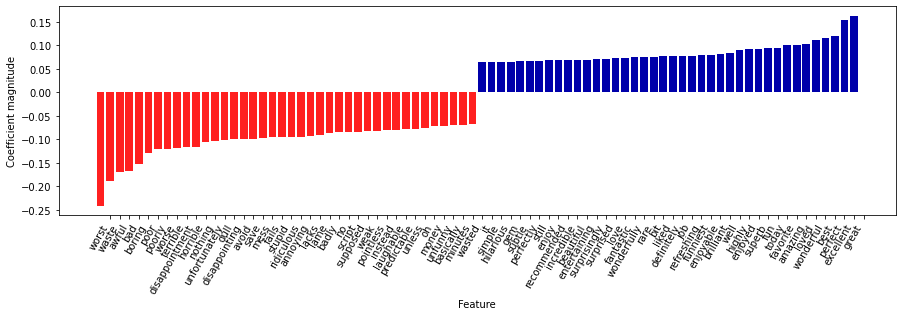

In [40]:
# 係数が最も大きい25の特徴量と最も小さい25の特徴量を示す
mglearn.tools.visualize_coefficients(
    grid.best_estimator_.named_steps['logisticregression'].coef_,
    feature_names, n_top_features=40)